In [1]:
# Import Resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

### Load in VGG19 (Features)

In [2]:
# Get the features portion of VGG19 (we do not need the classifier layer)
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we are only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load in Content and Style Images

In [4]:
def load_image(img_pth, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_pth).convert('RGB')
    
    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))
    ])
    
    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [5]:
# Load in content and style image
content = load_image('images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display

def im_convert(tensor):
    """ Displaying a Tensor as an Image """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

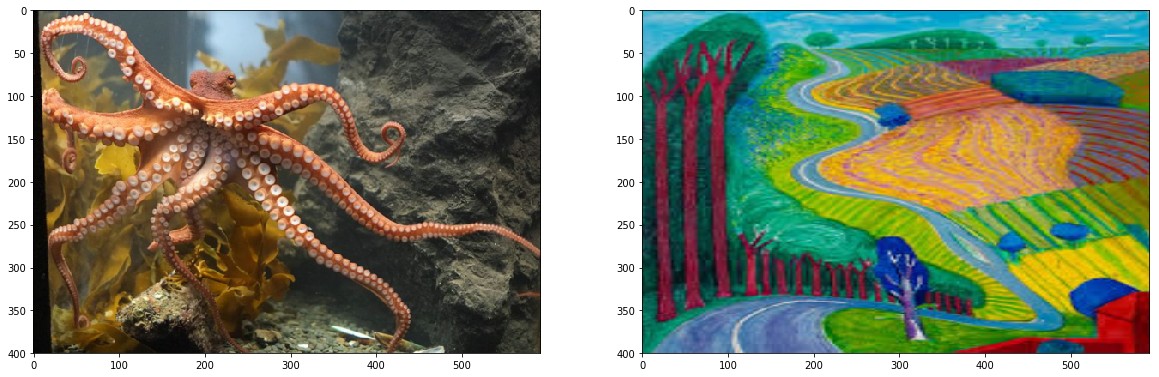

In [7]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Content and Style images side by side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## VGG19

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [8]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Content and Style Features

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2', ## Content representation
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features
        

## Gram Matrix

In [10]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h*w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [11]:
# Get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third target image and prep if for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

## Loss and Weights

Content and Style Weight
Just like in the paper, we define an alpha (content_weight) and a beta (style_weight). This ratio will affect how stylized your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [12]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target and calculating Losses

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our target image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! I recommend using at least 2000 steps for good results. But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, you'll calculate the content and style losses and update your target image, accordingly.

Content Loss
The content loss will be the mean squared difference between the target and content features at layer conv4_2. This can be calculated as follows:

content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
Style Loss
The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary style_weights.

You'll calculate the gram matrix for the target image, target_gram and style image style_gram at each of these layers and compare those gram matrices, calculating the layer_style_loss. Later, you'll see that this value is normalized by the size of the layer.

Total Loss
Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.

Total Loss:  49115020.0


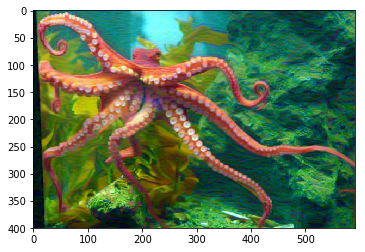

Total Loss:  9948831.0


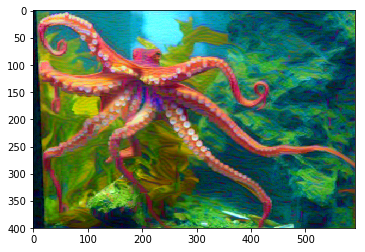

Total Loss:  5176209.0


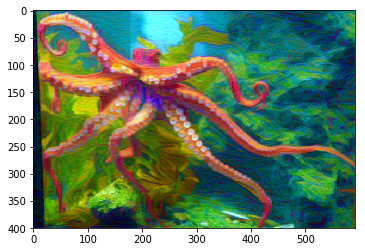

Total Loss:  3145292.5


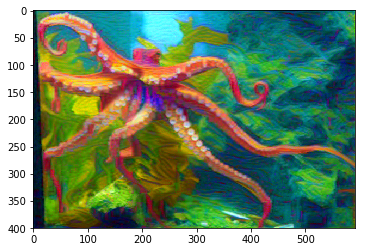

Total Loss:  2023501.5


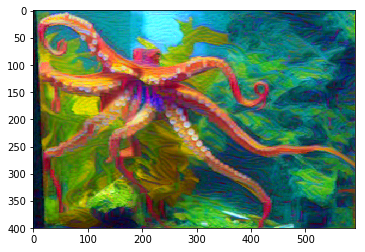

In [15]:
# For displaying the target image intermittently
show_every = 400
# Iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000 # Decide how many iterations to update your image (5000)

for ii in range (1, steps+1):
    # Get the features from your target image
    target_features = get_features(target, vgg)
    
    # Calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # The style loss
    # Initialize the style loss to 0
    style_loss = 0
    # Then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # Get the target style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # Get the style style representation
        style_gram = style_grams[layer]
        # The style loss for one layer weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) **2)
        # Add to the style loss
        style_loss += layer_style_loss / (d* h* w)
        
    # Calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Display intermediate images and print the loss
    if ii % show_every == 0:
        print('Total Loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

### Display the Target Image

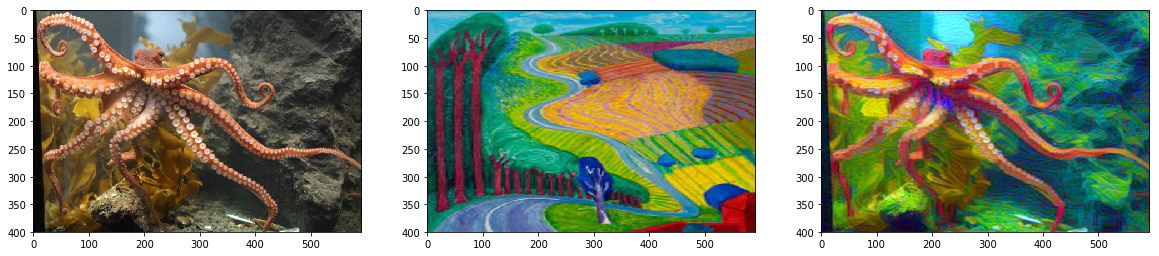

In [18]:
# display content, style and target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))
ax3.imshow(im_convert(target))

In [19]:
fig.savefig('Style_transfer.png')